In [1]:
from standardInclude import *

Welcome to JupyROOT 6.12/06
For interactive plots, run: setint()
To return to non-interactive plots (default state), run: noint()


### This notebook seeks to recreate the algorithm used in calculateDeltaTConstants.C from Jason in python, hopefully in a way that is a little more readable.

We will use the method detailed in note 16841 to construct a matrix of deltaT clusters for adjacent crystals in each calorimeter, and then use SciPy singular value decomposition in order to arrive at the xtal-to-xtal timing alignment constants for each calorimeter.

* Matrix = 1/-1 depending on the calorimeters being subtracted

* RHS = vector of deltaT values (mean from gaussian fit)

Both of these should be divided by the error in the mean from the gaussian fit

---

In [2]:
#open the file containing the hitDeltaTXXX histograms. These are produced as an output from:
#    https://cdcvs.fnal.gov/redmine/projects/gm2calo/repository/entry/analyses/NeighboringCrystalsTimeExtraction_module.cc?rev=run2Templates
f = r.TFile("./data/gm2deltaTAnalysis_full.root")
f.cd("neighboringCrystalsDeltaT")
f.ls()

TFile**		./data/gm2deltaTAnalysis_full.root	
 TFile*		./data/gm2deltaTAnalysis_full.root	
  TDirectoryFile*		neighboringCrystalsDeltaT	neighboringCrystalsDeltaT (NeighboringCrystalsTimeExtraction) folder
   KEY: TH3D	hitDeltaT0;1	calo 0 delta t
   KEY: TH3D	hitDeltaT1;1	calo 1 delta t
   KEY: TH3D	hitDeltaT2;1	calo 2 delta t
   KEY: TH3D	hitDeltaT3;1	calo 3 delta t
   KEY: TH3D	hitDeltaT4;1	calo 4 delta t
   KEY: TH3D	hitDeltaT5;1	calo 5 delta t
   KEY: TH3D	hitDeltaT6;1	calo 6 delta t
   KEY: TH3D	hitDeltaT7;1	calo 7 delta t
   KEY: TH3D	hitDeltaT8;1	calo 8 delta t
   KEY: TH3D	hitDeltaT9;1	calo 9 delta t
   KEY: TH3D	hitDeltaT10;1	calo 10 delta t
   KEY: TH3D	hitDeltaT11;1	calo 11 delta t
   KEY: TH3D	hitDeltaT12;1	calo 12 delta t
   KEY: TH3D	hitDeltaT13;1	calo 13 delta t
   KEY: TH3D	hitDeltaT14;1	calo 14 delta t
   KEY: TH3D	hitDeltaT15;1	calo 15 delta t
   KEY: TH3D	hitDeltaT16;1	calo 16 delta t
   KEY: TH3D	hitDeltaT17;1	calo 17 delta t
   KEY: TH3D	hitDeltaT18;1	calo 18 delta t

In [3]:
calo = 2
h = f.Get("neighboringCrystalsDeltaT/hitDeltaT"+str(calo)).Clone("h_"+str(calo))
h.SetDirectory(0)

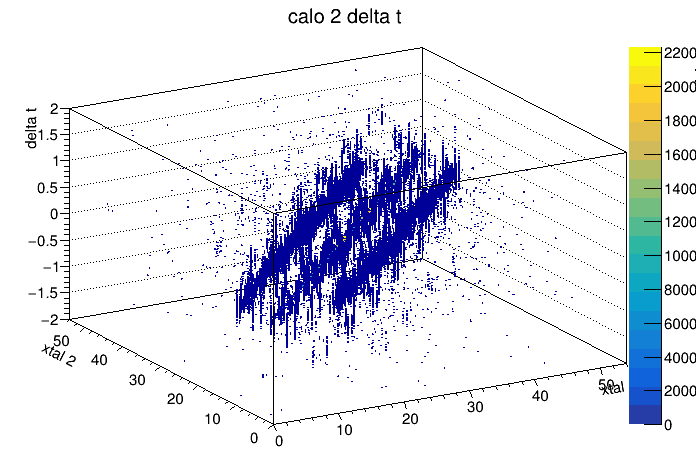

In [4]:
c = r.TCanvas()
h.Draw("lego2z")
c.Draw()

In [5]:
#converts xtal number into x/y position in calorimeter and vice versa
def xtalNumToPosition(x, y = np.nan):
    #if we are given two values, convert xtal position in calo to xtal number
    if(y is not np.nan):
        return x + y*9
    else:
        return (x % 9, int(np.floor(x/9)))

#returns the neighboring crystals in a grid in the form of an iterator
def ReturnNeighbors_NoDiagonal(x, y):
    for i in range(x - 1, x + 2):
        for j in range(y - 1, y + 2):
            if (((i, j) != (x, y)) and i < 9 and j < 6 and i > -1 and j > -1):
                #print(np.abs(i-x) + np.abs(j-y), i, j )
                if(np.abs(i-x) + np.abs(j-y) < 2):
                    yield (int(i), int(j))

In [6]:
#this crystals deltaT value will be set to 0 as a reference
xtalToFix = 0

In [7]:
#xtals which are dead or should otherwise just be set to 0
skipXtals = [
    #(15,2)
]

Starting calo 1
Starting calo 2
Starting calo 3
Starting calo 4
Starting calo 5
Starting calo 6
Starting calo 7
Starting calo 8
Starting calo 9
Starting calo 10
Starting calo 11
Starting calo 12
Starting calo 13
Starting calo 14
Starting calo 15
     Empty Fit Data in xtal pair 1 / 2
     Empty Fit Data in xtal pair 2 / 1
     Empty Fit Data in xtal pair 2 / 11
     Empty Fit Data in xtal pair 2 / 3
     Empty Fit Data in xtal pair 3 / 2
     Empty Fit Data in xtal pair 11 / 2
Starting calo 16
Starting calo 17
Starting calo 18
Starting calo 19
Starting calo 20
Starting calo 21
Starting calo 22
Starting calo 23
Starting calo 24


Warning in <Fit>: Fit data is empty 
Warning in <Fit>: Fit data is empty 
Warning in <Fit>: Fit data is empty 
Warning in <Fit>: Fit data is empty 
Warning in <Fit>: Fit data is empty 
Warning in <Fit>: Fit data is empty 
Warning in <Fit>: Fit data is empty 
Warning in <Fit>: Fit data is empty 
Warning in <Fit>: Fit data is empty 
Warning in <Fit>: Fit data is empty 
Warning in <Fit>: Fit data is empty 
Warning in <Fit>: Fit data is empty 
Warning in <Fit>: Fit data is empty 
Warning in <Fit>: Fit data is empty 
Warning in <Fit>: Fit data is empty 
Warning in <Fit>: Fit data is empty 
Warning in <Fit>: Fit data is empty 
Warning in <Fit>: Fit data is empty 


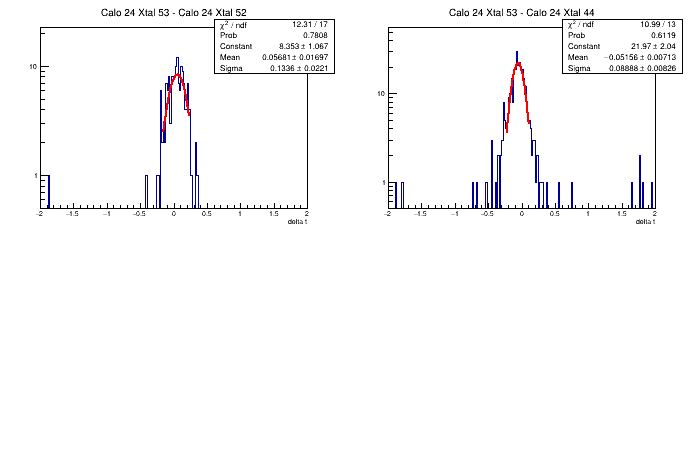

In [8]:
shape = (1,54) #shape of each row in the calorimeter matrix
caloMatrices = []

allChiSquareNDF = []
allN = []

allMeans = []
allCalos = []
allXtals = []

#for calo in [13,14]:
for calo in range(1,25):
    print("Starting calo", calo)
    
    #get the histogram for this calo
    h = f.Get("neighboringCrystalsDeltaT/hitDeltaT"+str(calo-1)).Clone("h_"+str(calo))
    h.SetDirectory(0)
    
    #create a matrix in which to store the xtal values and the deltaT value
    matrix = np.zeros(shape, dtype=float)
    rhs = np.zeros((1,1),dtype=float)
    #print(matrix)
    #print(rhs)

    takenPairs = [] #use this to avoid processing pairs like (1,0)/(0,1) twice. Just saves time.
    for xtal in range(54):
        adjXtals = [] #holds histograms from xtals adjacent to xtal
        c = r.TCanvas()
        c.Divide(2,2)
        i = 0
        #loop over the crystals which neighbor the reference xtal
        for x2, y2 in ReturnNeighbors_NoDiagonal(xtalNumToPosition(xtal)[0],xtalNumToPosition(xtal)[1]):
            c.cd(i+1)
            xtal2 = xtalNumToPosition(x2,y2) #convert positions in the caloriemter into an xtal number
            
            #get and draw the deltaT histogram for this pair of crystals
            bin_xtal = h.GetXaxis().FindBin(xtal)
            bin_xtal2 = h.GetYaxis().FindBin(xtal2)
            h.GetXaxis().SetRange(bin_xtal, bin_xtal)
            h.GetYaxis().SetRange(bin_xtal2, bin_xtal2)
            hi = h.Project3D("z").Clone("h_"+str(xtal2))
            hi.SetTitle("Calo "+str(calo)+" Xtal "+str(xtal)+" - "+"Calo "+str(calo)+" Xtal "+str(xtal2))
            allN.append(hi.GetEntries())
            adjXtals.append(hi.Clone("h_"+str(xtal2)))
            adjXtals[i].Draw()
            r.gPad.SetLogy()

            #calculate the mean and weight of the deltaT histogram
            mean = hi.GetMean() #initial values, later changed to values from gaussian fit
            weight = 1
            
            #fit the deltaT histogram using a gaussian. We can play with the range here to ensure good fits.
            func = r.TF1("func","gaus",-10,10)
            func.SetParameters(1,mean,0.3)
            for ieunerin in range(2):
                adjXtals[i].Fit(func,"REMBQ","")#, mean-0.5, mean+0.5)
            sigma = func.GetParameter(2)
            mean = func.GetParameter(1)
            func.SetParLimits(1,mean-0.5, mean+0.5)
            adjXtals[i].Fit(func,"REMBQ","", mean-1.5*sigma, mean+1.5*sigma)
            
            #from the fit, calculate new values of the mean/weight
            try: #if the fit worked (i.e. the histogram was not empty) this should succeed
                allChiSquareNDF.append( func.GetChisquare() / func.GetNDF() )
                if(func.GetChisquare() / func.GetNDF() < 10):
                    #mean = hi.GetMean()
                    #weight = hi.GetRMS()
                    mean = func.GetParameter(1)
                    #weight = func.GetParameter(2)
                    weight = func.GetParError(1)
                else:
                    print("     Bad xtal", xtal2)
            except:
                allChiSquareNDF.append(0)
                print("     Empty Fit Data in xtal pair", xtal, "/", xtal2)
                
            #save some values for verification plots later
            allMeans.append((mean,weight))
            allXtals.append((calo-1)*54 + xtal)
            allCalos.append(calo)
            #print(mean,stdev)

            #create a new row in each of the matrices and set the values accordingly
            newMatrixRow = [[0 for i in range(54)]]
            if((xtal == xtalToFix) or ((calo,xtal) in skipXtals)):
                #print(calo,xtal)
                #this being set to a very large number effectively fixes the constant for this xtal at 0
                newMatrixRow[0][xtal] = +10000000
                newRHS = [[0]]
            else:
                newMatrixRow[0][xtal] = +1/weight
                newRHS = [[mean/weight]]
                newMatrixRow[0][xtal2] = -1/weight 
            #print(newMatrixRow)

            #append these rows to the existing matrices and update the pairs which have been processed
            if( (xtal, xtal2) not in takenPairs and (xtal2, xtal) not in takenPairs ):
                matrix = np.append(matrix, newMatrixRow, 0)
                rhs = np.append(rhs, newRHS, 0)
                takenPairs.append((xtal,xtal2))
                
            i+=1

        #hi.Draw()
        c.Draw()
        #c.Print("./images/deltat/DeltaT_Calo_"+str(calo).zfill(2)+"_Xtal_"+str(xtal).zfill(2)+"_Xtal2_"+str(xtal2).zfill(2)+".png")

    #delete first placeholder row of all zeros from the matrices
    matrix = np.delete(matrix, 0, 0)
    rhs = np.delete(rhs, 0, 0)
    
    #add to running list of matrices for all calos
    caloMatrices.append((calo, matrix, rhs))

---

### Some verification plots for the fits

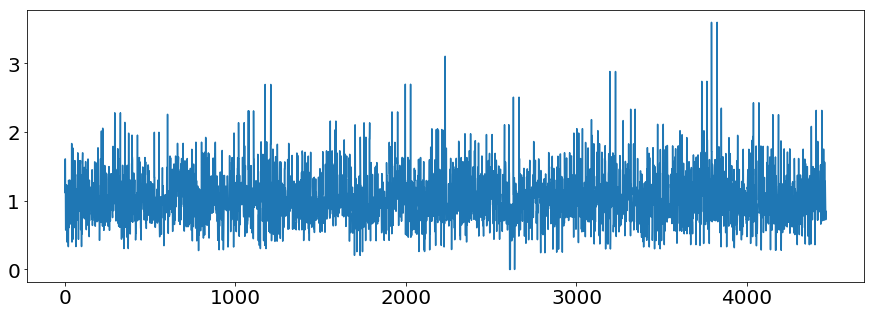

In [9]:
fig,ax = plt.subplots(figsize=(15,5))

plt.plot(allChiSquareNDF)
#plt.plot([0,len(allChiSquareNDF)], [10,10])
plt.show()

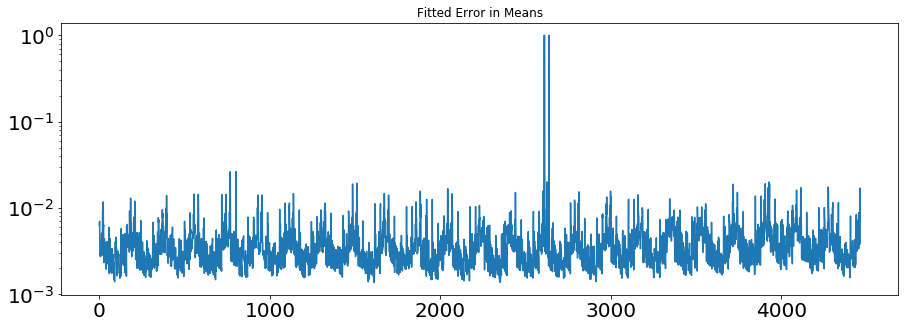

In [10]:
means, stdevs = zip(*allMeans)

fig,ax = plt.subplots(figsize=(15,5))

plt.plot([y for x,y in allMeans])
#plt.plot([0,len(allChiSquareNDF)], [10,10])
plt.title("Fitted Error in Means")
plt.yscale("log")
plt.show()

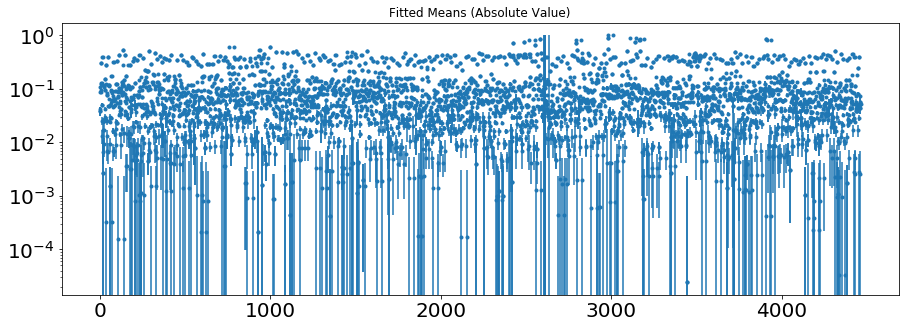

In [11]:
means, stdevs = zip(*allMeans)

fig,ax = plt.subplots(figsize=(15,5))

plt.errorbar([x for x in range(len(means))], np.abs(means), yerr=stdevs, fmt=".")
#plt.plot([0,len(allChiSquareNDF)], [10,10])
plt.title("Fitted Means (Absolute Value)")
plt.yscale("log")
plt.show()

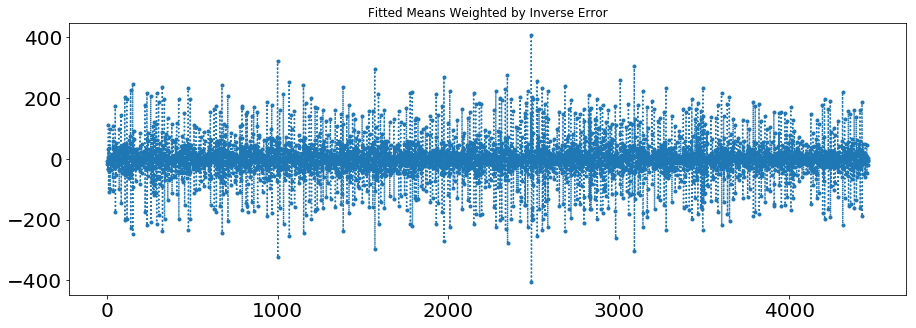

In [12]:
fig,ax = plt.subplots(figsize=(15,5))

plt.errorbar([x for x in range(len(means))], [x/y for x,y in allMeans], yerr=0, fmt=".:")
plt.title("Fitted Means Weighted by Inverse Error")
#plt.yscale("log")
plt.show()

/home/jlab/anaconda3/lib/python3.6/site-packages/numpy/lib/type_check.py:546: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  'a.item() instead', DeprecationWarning, stacklevel=1)


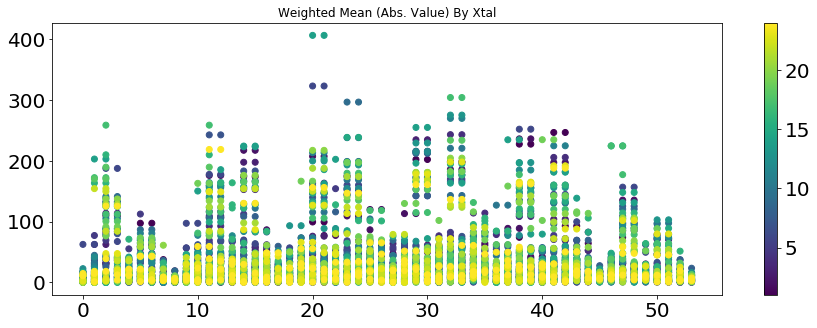

In [13]:
fig,ax = plt.subplots(figsize=(15,5))
plt.scatter([x%54 for x in allXtals], [np.abs(x/y) for x,y in allMeans], 
            c=allCalos, 
            vmin=1,
            vmax=24
           )
plt.colorbar()
plt.title("Weighted Mean (Abs. Value) By Xtal")
plt.show()

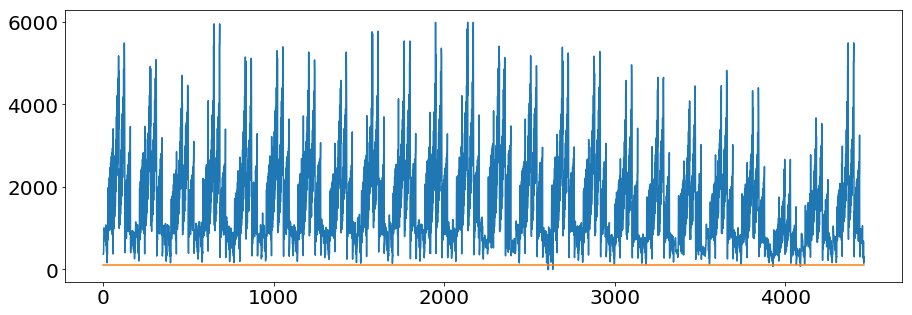

In [14]:
fig,ax = plt.subplots(figsize=(15,5))

plt.plot(allN)
plt.plot([0,len(allChiSquareNDF)], [100,100])
#plt.ylim(0,250)
plt.show()

---

### Now lets take a look at the matrices we generated

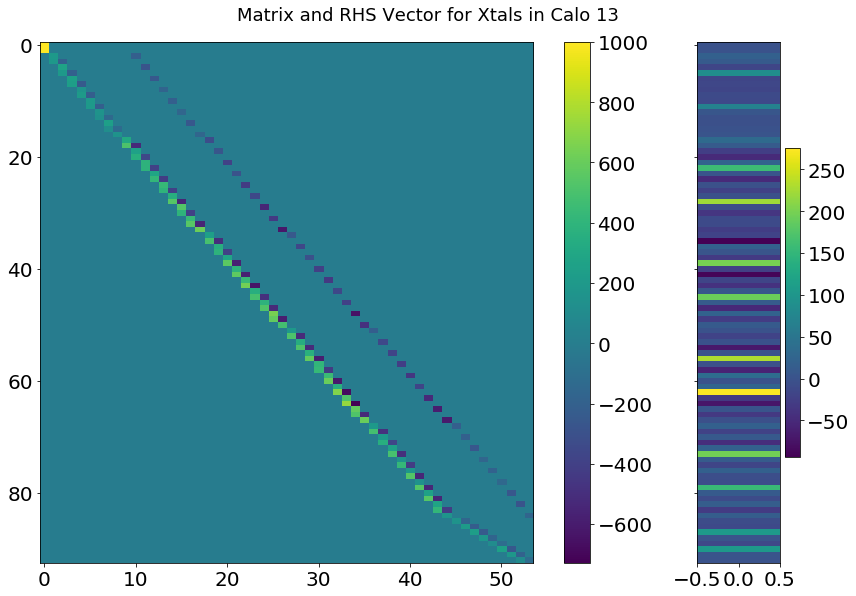

In [15]:
fig,ax = plt.subplots(1,2,figsize=(12,8), gridspec_kw={'width_ratios': [6, 1]}, sharey=True)
calo = 13
im = ax[0].imshow(caloMatrices[calo-1][1],
           #norm=matplotlib.colors.LogNorm(), 
           #vmin=-20, 
           vmax=1000,
           aspect='auto')
im2 = ax[1].imshow(caloMatrices[calo-1][2],
           #norm=matplotlib.colors.LogNorm(), 
           #vmin=-20, 
           #vmax=20,
           aspect='auto')
plt.colorbar(im, ax=ax[0])
plt.colorbar(im2, ax=ax[1])

plt.suptitle("Matrix and RHS Vector for Xtals in Calo "+str(calo), y=1.03, fontsize=18)
plt.tight_layout()

plt.show()

---

### Now lets solve for the timing constants for each calorimeter.

We do this suing singular value decomposition. This can be accomplished using a number of tools, but we will use numpy's lstsq (and scipy's lsq_linear as a cross check)

In [16]:
#now lets do the SVD using numpy
#    see: https://docs.scipy.org/doc/numpy/reference/generated/numpy.linalg.svd.html
caloSVD = []
from scipy import optimize

for calo, matrix, rhs in caloMatrices:
    if(False): #use least squares method from numpy
        timeConstants, residuals, rankOfMatrix, singularValuesOfMatrix  = np.linalg.lstsq(matrix, rhs)
        timeConstants = timeConstants*-1 #invert calculated values to agree with conventions
        caloSVD.append( (calo, timeConstants, residuals, rankOfMatrix, singularValuesOfMatrix) )
    else: #use least squares from scipy
        rhsVec = np.ndarray.flatten(rhs)
        timeConstants = scipy.optimize.lsq_linear(matrix, rhsVec)
        caloSVD.append((calo, timeConstants['x']*-1, timeConstants))

/home/jlab/anaconda3/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: numpy.ufunc size changed, may indicate binary incompatibility. Expected 192 from C header, got 216 from PyObject
  return f(*args, **kwds)
/home/jlab/anaconda3/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: numpy.ufunc size changed, may indicate binary incompatibility. Expected 192 from C header, got 216 from PyObject
  return f(*args, **kwds)


In [17]:
print([x[0] for x in caloSVD])

[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24]


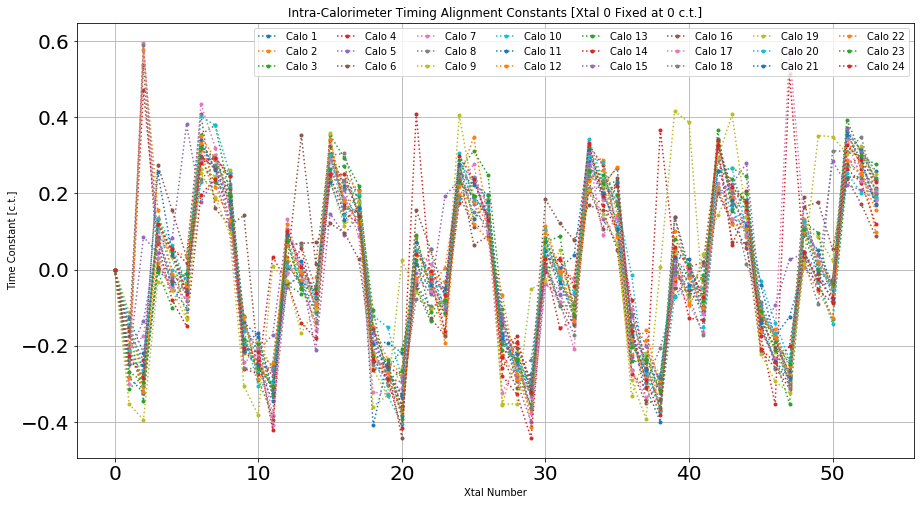

In [18]:
fig, ax = plt.subplots(figsize=(15,8))
#plt.ylim(-0.3,0.6)
for calo in range(24):
    plt.plot([i for i in range(54)], caloSVD[calo][1], ".:", label="Calo "+str(calo+1))
plt.legend(ncol=8)
plt.title("Intra-Calorimeter Timing Alignment Constants [Xtal "+str(xtalToFix)+" Fixed at 0 c.t.]")
plt.xlabel("Xtal Number")
plt.ylabel("Time Constant [c.t.]")
plt.grid()
plt.show()

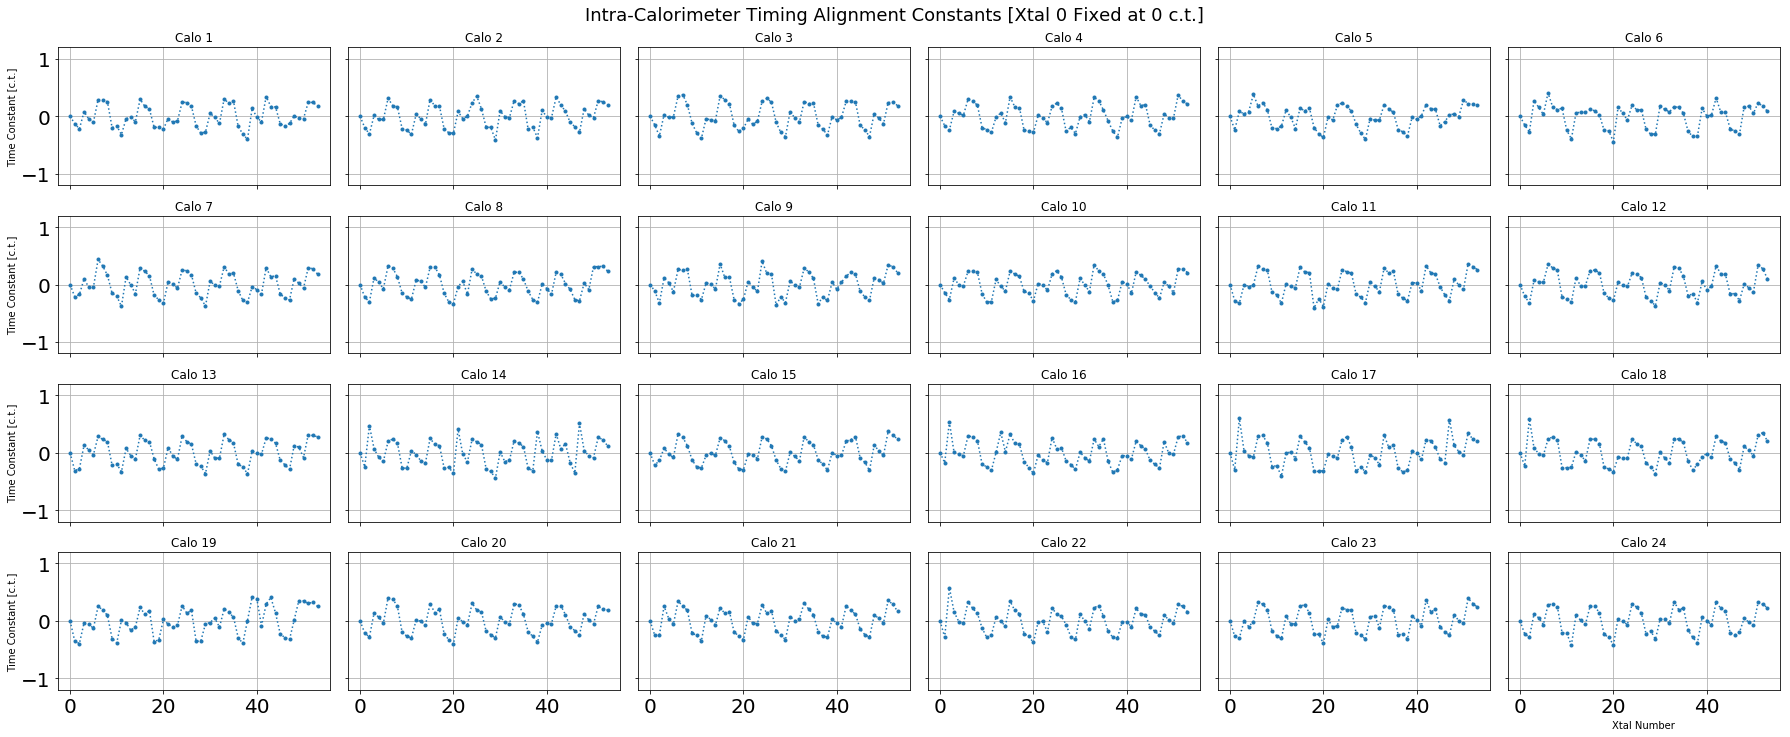

In [19]:
fig, axs = plt.subplots(4,6,figsize=(25,10), sharex=True, sharey=True)
#plt.ylim(-0.3,0.6)
ax = flatten2dArray(axs)
for calo in range(24):
    ax[calo].plot([i for i in range(54)], caloSVD[calo][1], ".:", label="Calo "+str(calo+1))
    ax[calo].set_title("Calo "+str(calo+1))
    ax[calo].grid()
    if(calo % 6 == 0):
        ax[calo].set_ylabel("Time Constant [c.t.]")
#plt.legend(ncol=8)
plt.suptitle("Intra-Calorimeter Timing Alignment Constants [Xtal "+str(xtalToFix)+" Fixed at 0 c.t.]",y=1.02, fontsize=18)
plt.xlabel("Xtal Number")
plt.tight_layout()
plt.ylim(-1.2,1.2)
plt.show()

---

### Now lets compare with the values calculated by Jasons macro with the same parameters

For his constants, the value of xtal 0 is fixed

In [21]:
jasonConstants = [[np.nan for i in range(54)] for i in range(24)]

calo = -1
with open("./data/jasonConstants.txt") as file:
    for line in file:
        #print(line)
        if("Calo" in line):
            #print(line.split(" "))
            calo = int(line.split(" ")[3])
        if("xtal" in line):
            xtal = int(line.split(" ")[0].split('xtal')[1])
            constant = line.split(" ")[2].split("\n")[0]
            #print(calo, xtal, constant)
            jasonConstants[calo -1][xtal] = float(constant)
        if(jasonConstants[23][53] is not np.nan):
            break  

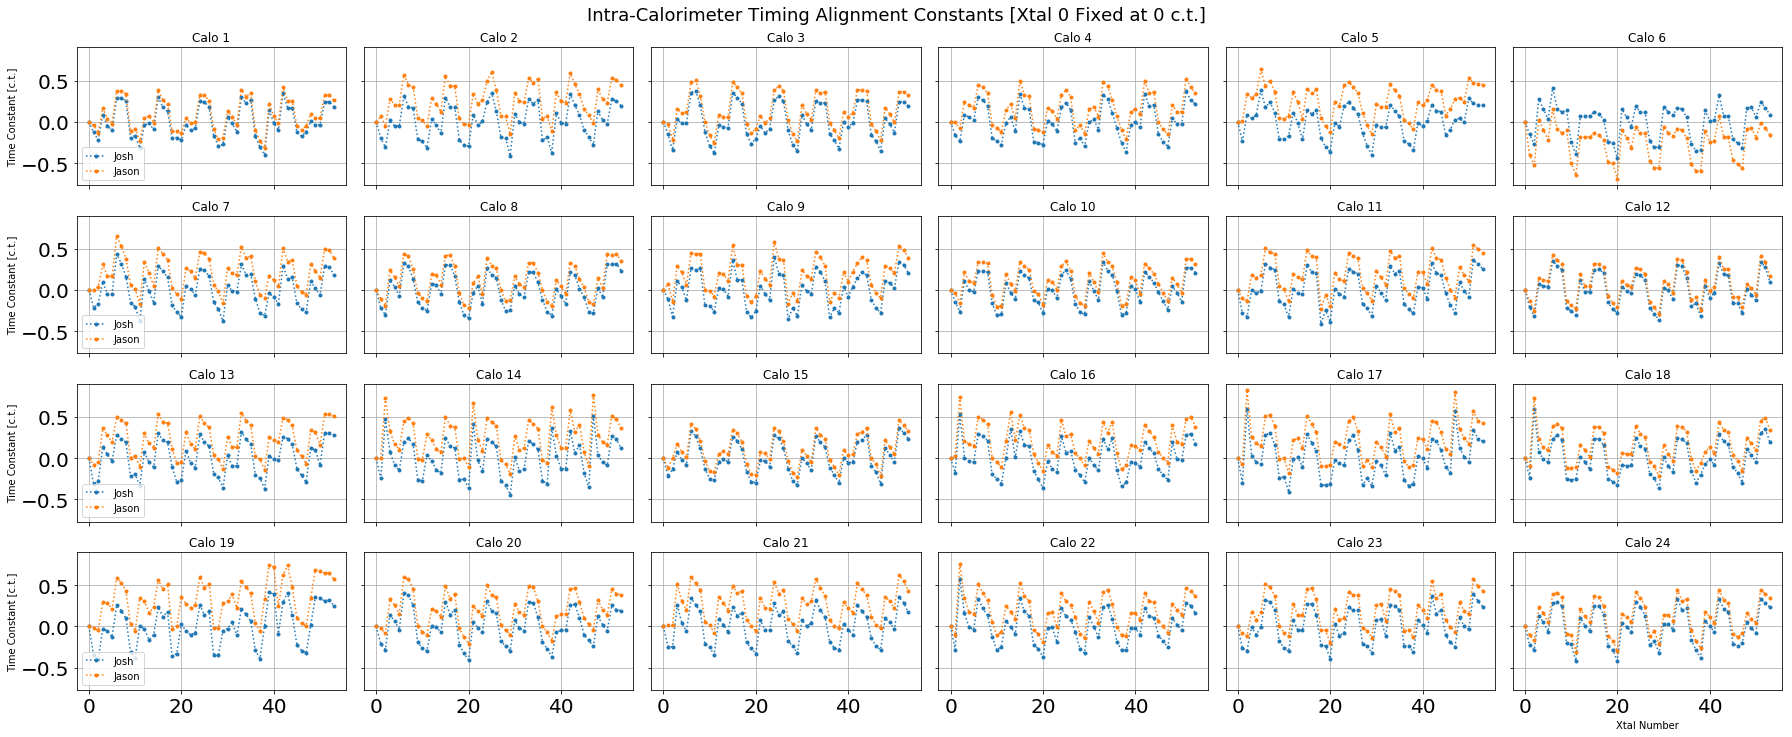

In [22]:
fig, axs = plt.subplots(4,6,figsize=(25,10), sharex=True, sharey=True)
#plt.ylim(-0.3,0.6)
ax = flatten2dArray(axs)
for calo in range(24):
    ax[calo].plot([i for i in range(54)], caloSVD[calo][1], ".:", label="Josh")
    ax[calo].plot([i for i in range(54)], jasonConstants[calo], ".:", label="Jason")
    ax[calo].set_title("Calo "+str(calo+1))
    ax[calo].grid()
    if(calo % 6 == 0):
        ax[calo].set_ylabel("Time Constant [c.t.]")
        ax[calo].legend(loc=3)
plt.suptitle("Intra-Calorimeter Timing Alignment Constants [Xtal "+str(xtalToFix)+" Fixed at 0 c.t.]",y=1.02, fontsize=18)
plt.xlabel("Xtal Number")
plt.tight_layout()
#plt.ylim(-1.2,1.2)
plt.show()

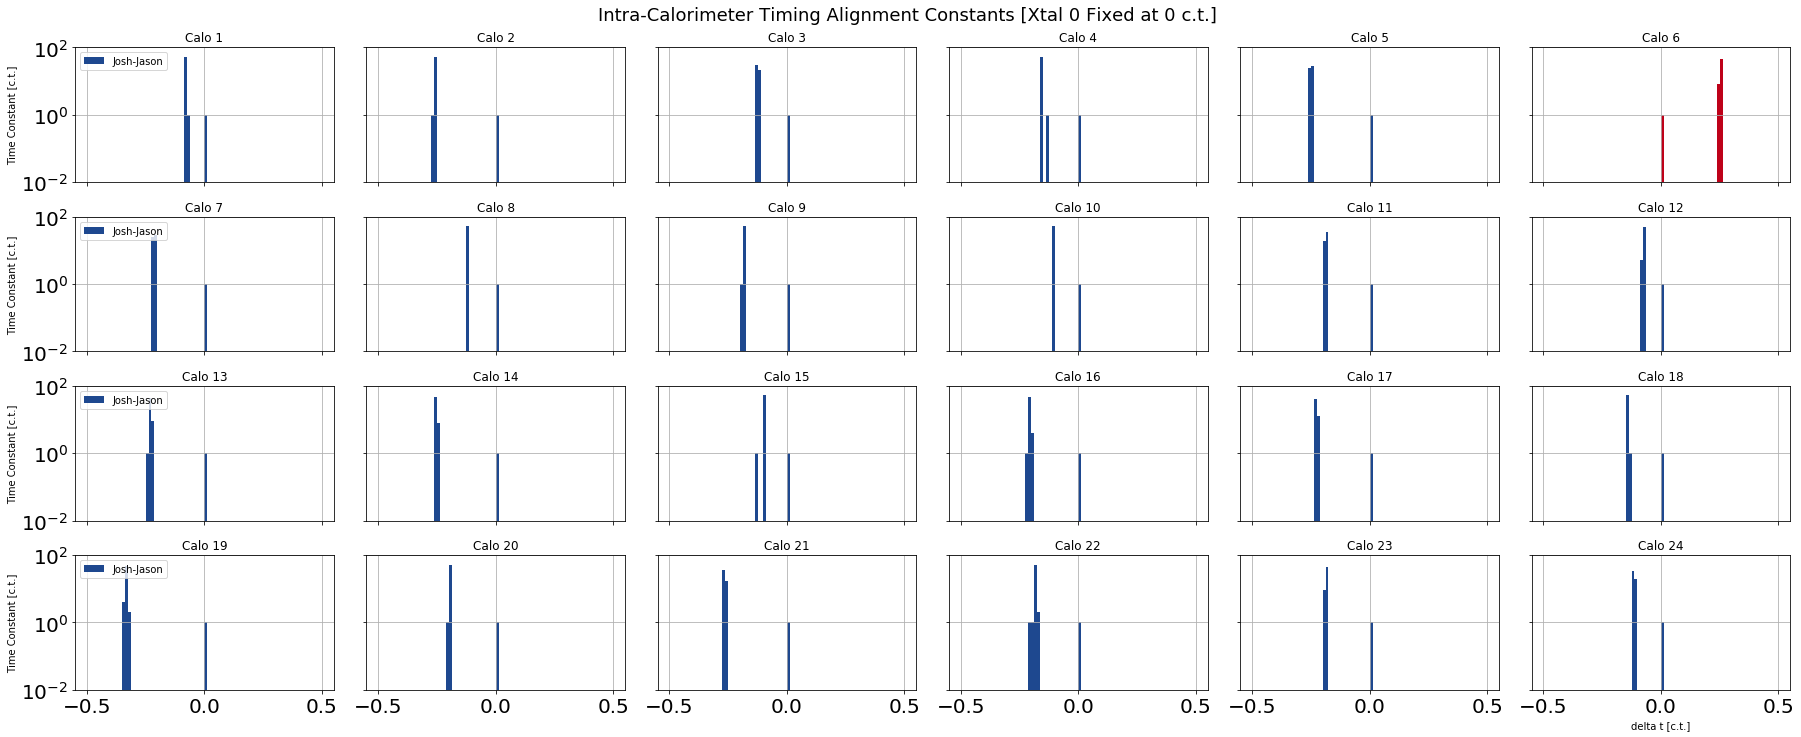

In [23]:
fig, axs = plt.subplots(4,6,figsize=(25,10), sharex=True, sharey=True)
#plt.ylim(-0.3,0.6)
ax = flatten2dArray(axs)
colors = ['xkcd:scarlet','xkcd:cobalt']
for calo in range(24):
    diff = [float(x)-y for (x,y) in zip(caloSVD[calo][1], jasonConstants[calo])]
    if(np.mean(diff)>0):
        ax[calo].hist(diff, bins=80, label="Josh-Jason", range=(-0.5,0.5), color=colors[0])
    else:
        ax[calo].hist(diff, bins=80, label="Josh-Jason", range=(-0.5,0.5), color=colors[1])
    #ax[calo].hist(diff, bins=80, label="Josh-Jason", range=(-0.5,0.5), color=colors[int(np.floor(calo/4) % 2)])
    ax[calo].set_title("Calo "+str(calo+1))
    ax[calo].grid()
    ax[calo].set_yscale("log")
    if(calo % 6 == 0):
        ax[calo].set_ylabel("Time Constant [c.t.]")
        ax[calo].legend(loc=2)
plt.suptitle("Intra-Calorimeter Timing Alignment Constants [Xtal "+str(xtalToFix)+" Fixed at 0 c.t.]",y=1.02, fontsize=18)
plt.xlabel("delta t [c.t.]")
plt.tight_layout()
plt.ylim(0.01,100)
#plt.xlim(-0.5,0.5)
plt.show()

---

### Now lets generate the fcl file for the timing offsets